In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.scrna_dataset as scrna_dataset
import model.sdes as sdes
import model.generate as generate
import model.scrna_ae as scrna_ae
import model.util as model_util
import analysis.fid as fid
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os
import h5py

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the model path and branches

In [3]:
model_path = "/gstore/scratch/u/tsenga5/branched_diffusion/models/trained_models/scrna_covid_flu_continuous_labelguided_9classes_latent_d200/3/last_ckpt.pth"

In [4]:
# classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

classes = [0, 1, 2, 3, 4, 5, 7, 10, 12]

# classes = [0]

# classes = [0, 1, 5]

In [5]:
latent_space = True
latent_dim = 200

### Create the data loader

In [6]:
data_file = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/processed/covid_flu_processed_reduced_genes.h5"
autoencoder_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_processed_reduced_genes_ldvae_d%d/" % latent_dim

dataset = scrna_dataset.SingleCellDataset(data_file, autoencoder_path=(autoencoder_path if latent_space else None))

# Limit classes
inds = np.isin(dataset.cell_cluster, classes)
dataset.data = dataset.data[inds]
dataset.cell_cluster = dataset.cell_cluster[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

[rank: 0] Global seed set to 0


INFO     File                                                                                                      
         /gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_proc
         essed_reduced_genes_ldvae_d200/model.pt already downloaded                                                


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/gstore/home/tsenga5/miniconda3/envs/scanpy/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [7]:
# Import gene names and marker genes
with h5py.File(data_file, "r") as f:
    gene_names = f["gene_names"][:].astype(str)
    marker_genes = {}
    for class_i in classes:
        marker_genes[class_i] = f["marker_genes"][str(class_i)][:].astype(str)
    
genes_of_interest = np.array(["NFKB1", "NFKB2", "IRF1", "CXCR3", "CXCL10", "STAT1", "TLR4", "TGFB1", "IL1B", "IFNG", "TLR4", "TNFSF4", "IL1R2", "IL1B", "IL7R", "IL32"])

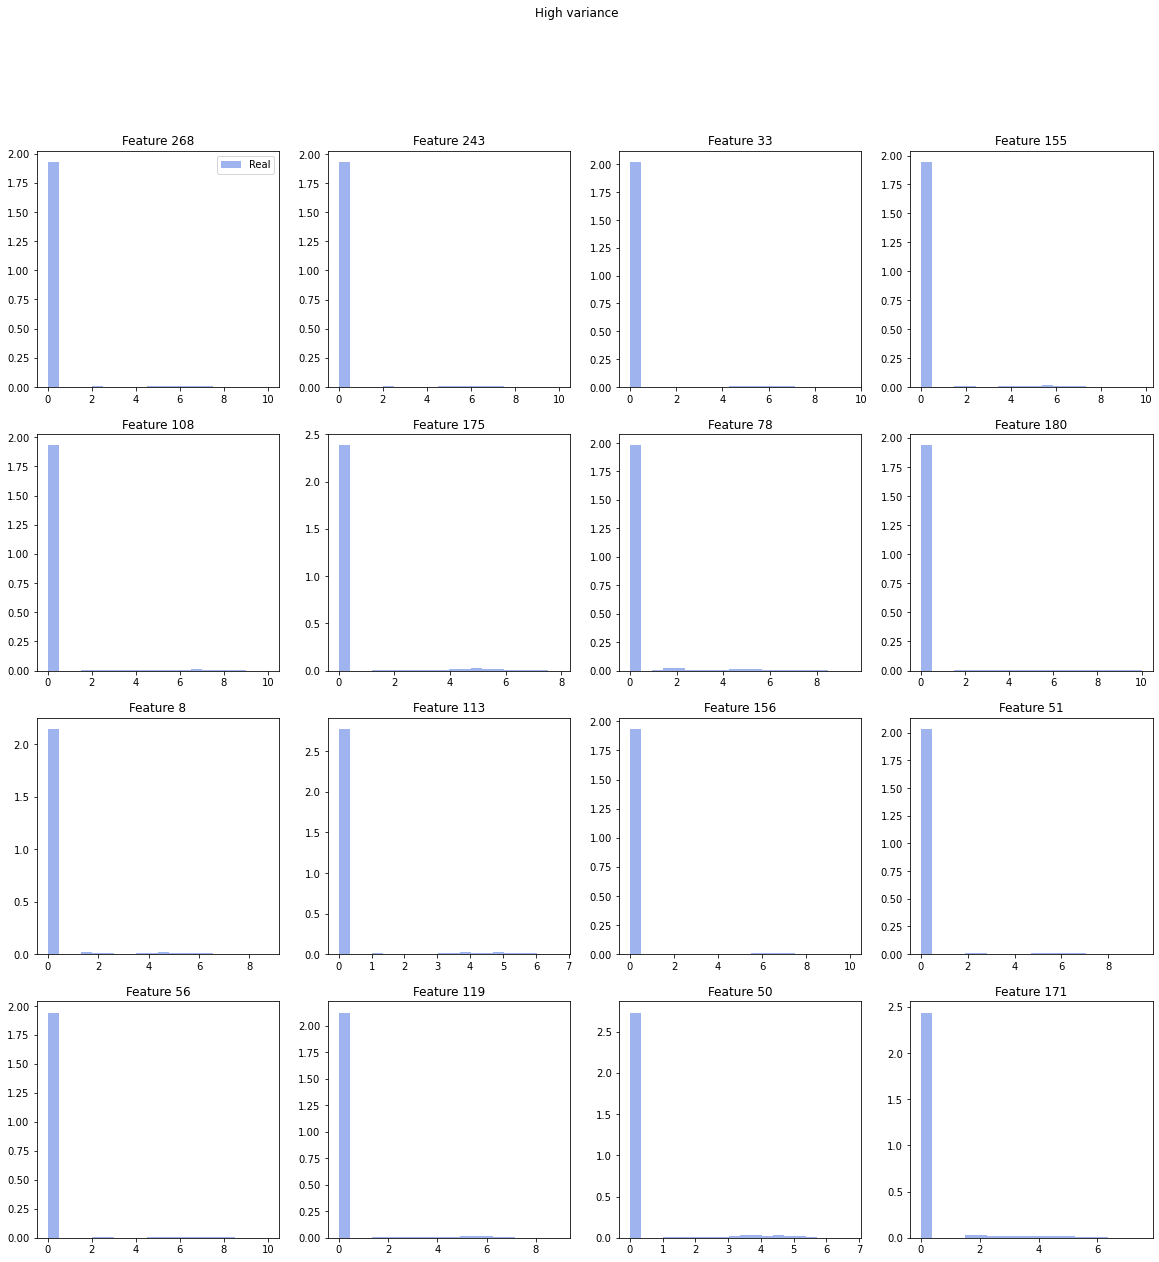

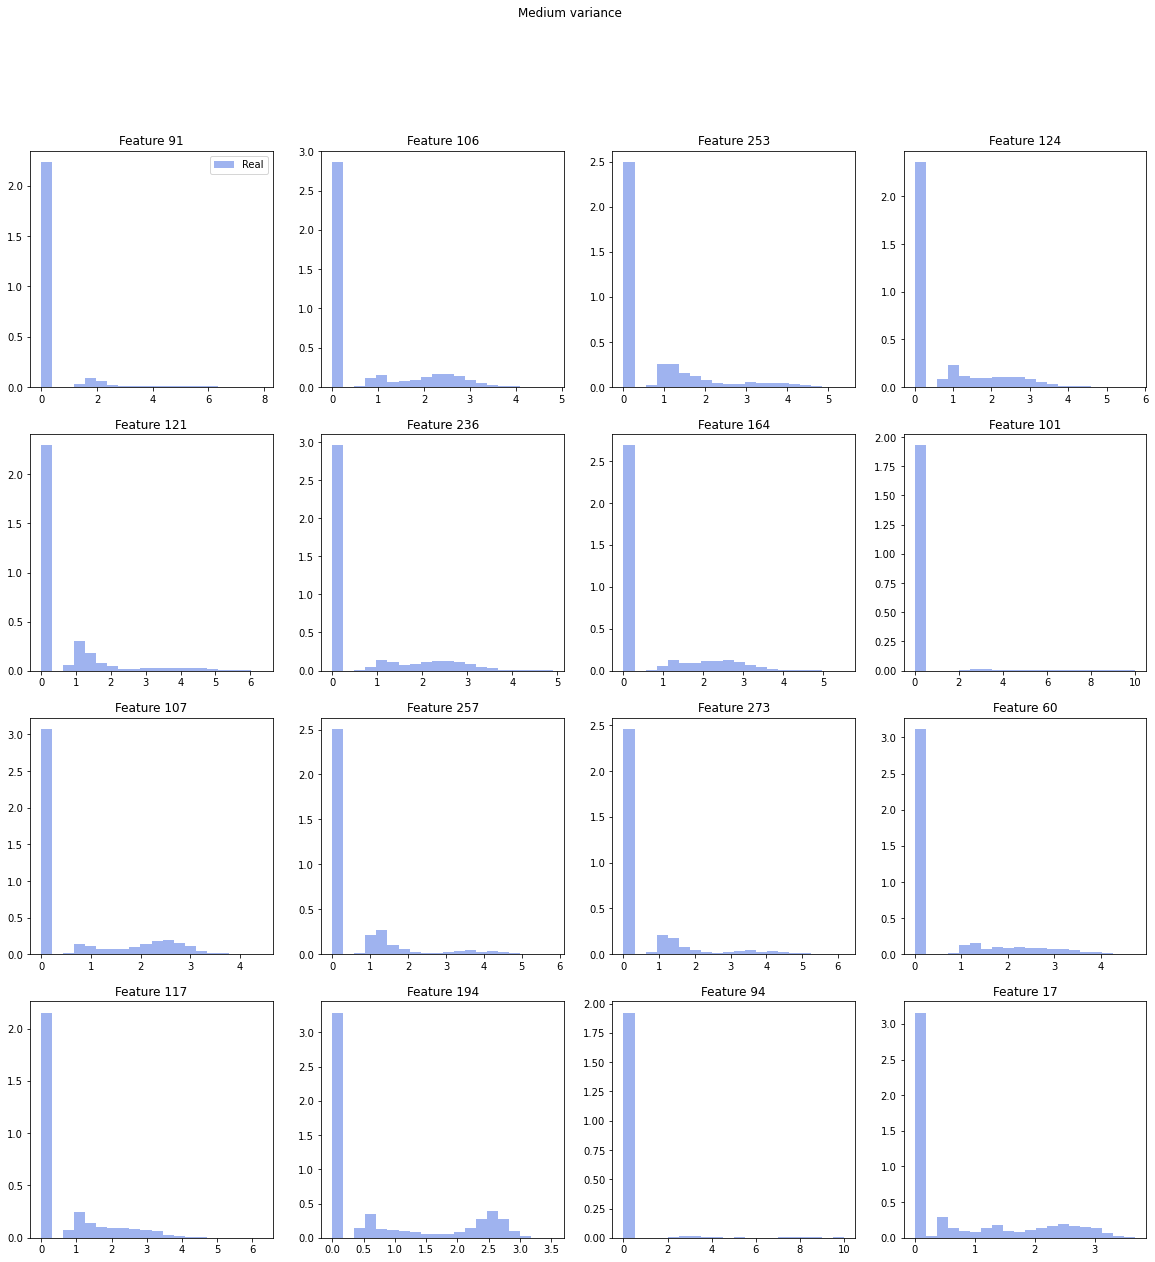

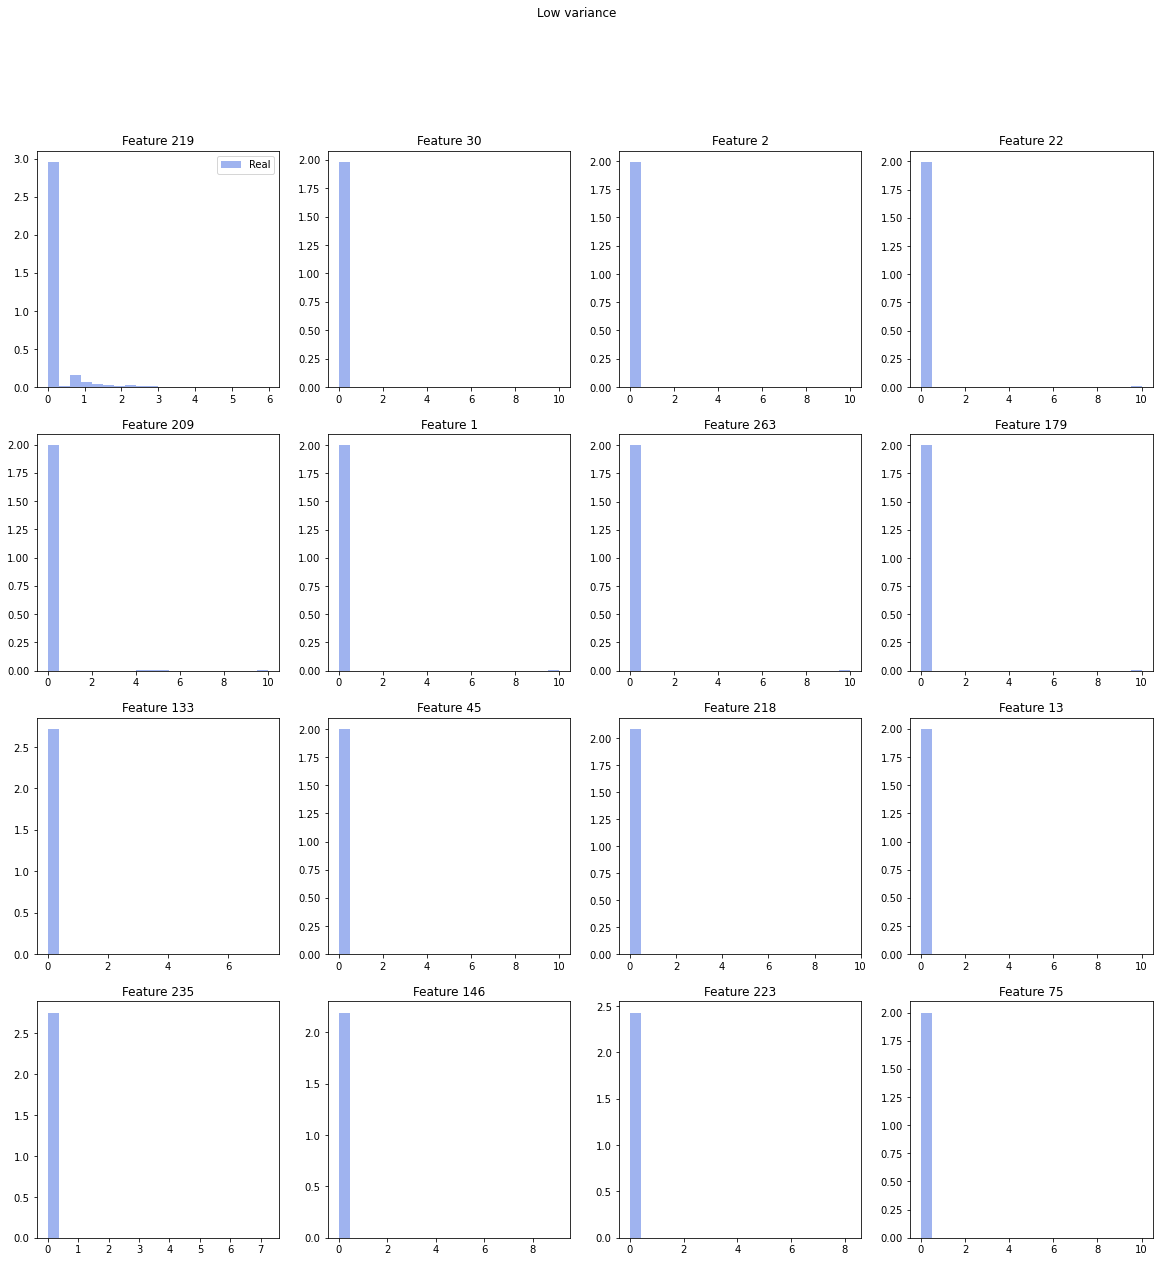

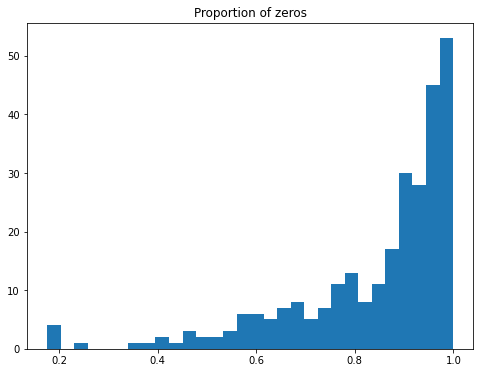

In [8]:
# Plot features
x = dataset.data
inds = np.flip(np.argsort(np.std(x, axis=0)))
num_features = 16
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
num_bins = 20

for name, feature_inds in [
    ("High variance", inds[:num_features]),
    ("Medium variance", inds[(len(inds) // 2) - (num_features // 2):(len(inds) // 2) - (num_features // 2) + num_features]),
    ("Low variance", inds[-num_features:])
]:
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        vals = x[:, f_i]
        ax[r][c].hist(vals, bins=num_bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % f_i)
    ax[0][0].legend()
    fig.suptitle(name)
    plt.show()
    
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(np.sum(x == 0, axis=0) / x.shape[0], bins=30)
ax.set_title("Proportion of zeros")
plt.show()

In [9]:
def class_to_class_index_tensor(c):
    """
    Given a tensor of classes, return the corresponding class indices
    as a tensor.
    """
    return torch.argmax(
        (c[:, None] == torch.tensor(classes, device=c.device)).int(), dim=1
    ).to(DEVICE)

In [10]:
# Create the SDE and import model
sde = sdes.VariancePreservingSDE(0.1, 5, input_shape)

t_limit = 1

model = model_util.load_model(
    scrna_ae.LabelGuidedResNet, model_path
).to(DEVICE)

### Show the forward-diffusion process

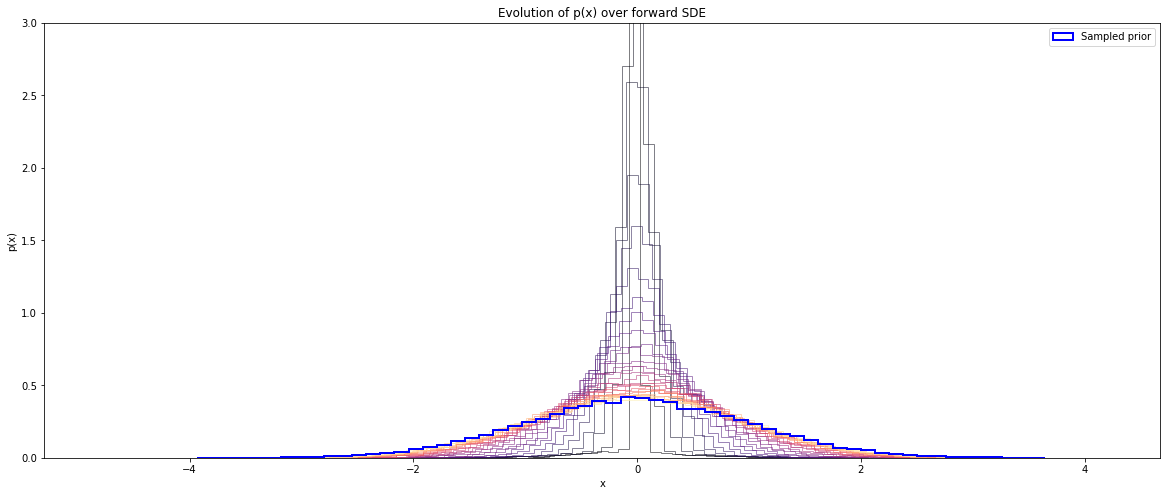

In [11]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Show generated distributions

In [12]:
gen_samples = {}
if latent_space:
    gen_latent_samples = {}
for class_to_sample in classes:
    sample = generate.generate_continuous_label_guided_samples(
        model, sde, class_to_sample, class_to_class_index_tensor,
        sampler="pc", t_limit=t_limit, num_steps=1000, verbose=True
    )
    if latent_space:
        gen_latent_samples[class_to_sample] = sample.cpu().numpy()
        sample = dataset.decode_batch(sample).cpu().numpy()
    gen_samples[class_to_sample] = sample

100%|█████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.60it/s]


In [13]:
# Sample objects from the original dataset
true_samples = {}
if latent_space:
    true_latent_samples = {}
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    inds = np.where(dataset.cell_cluster == class_to_sample)[0]
    sample_inds = np.random.choice(inds, size=min(500, len(inds)), replace=False)
    sample = dataset.data[sample_inds]
    if latent_space:
        true_latent_samples[class_to_sample] = dataset.encode_batch(torch.tensor(sample, device=DEVICE)).cpu().numpy()
    true_samples[class_to_sample] = sample

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 7
Sampling class: 10
Sampling class: 12


In [14]:
# Rescale sampled values to match range of true values based on standard deviation
def rescale_samples(samps, samp_class):
    t = true_samples[samp_class]

    s_z = (samps - np.mean(samps, axis=0, keepdims=True)) / np.std(samps, axis=0, keepdims=True)
    s_trans = (s_z * np.std(t, axis=0, keepdims=True)) + np.mean(t, axis=0, keepdims=True)
    
    return np.nan_to_num(s_trans)  # Convert NaNs to 0s

if latent_space:
    gen_samples_scaled = {}
    for class_to_sample in classes:
        gen_samples_scaled[class_to_sample] = rescale_samples(gen_samples[class_to_sample], class_to_sample)
else:
    gen_samples_scaled = gen_samples

Class 0


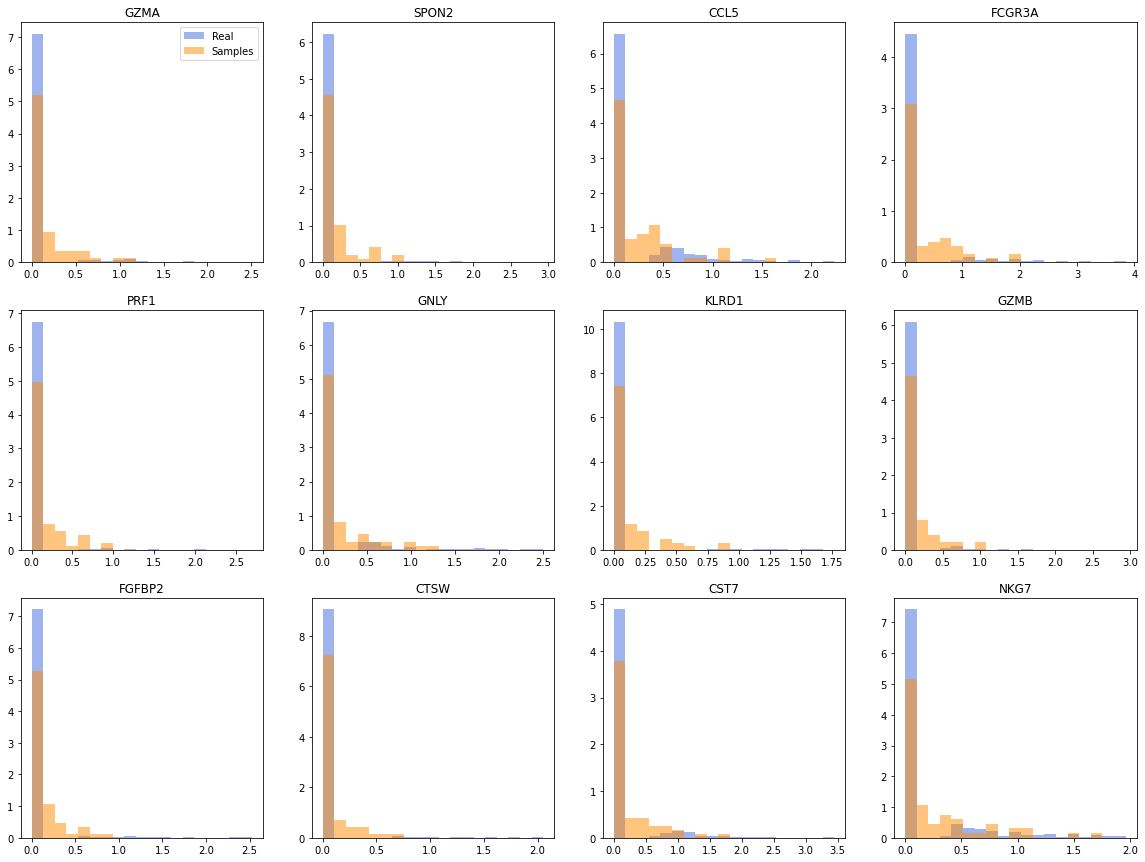

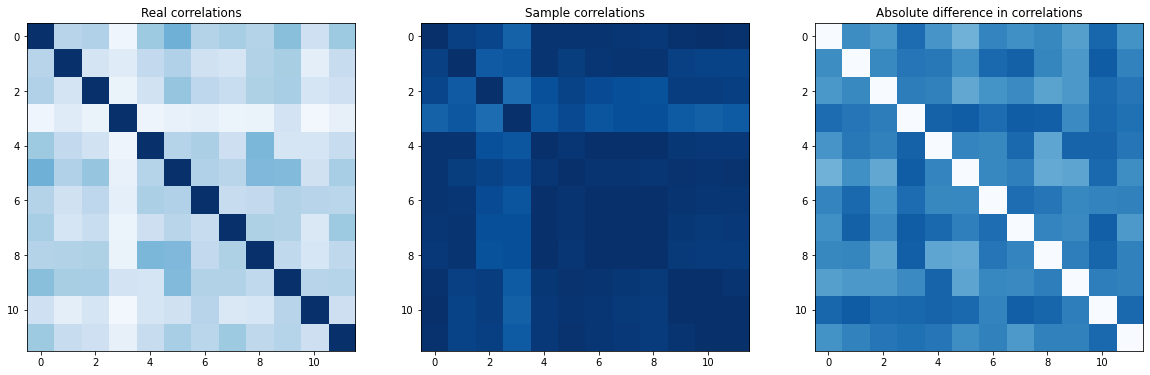

Class 1


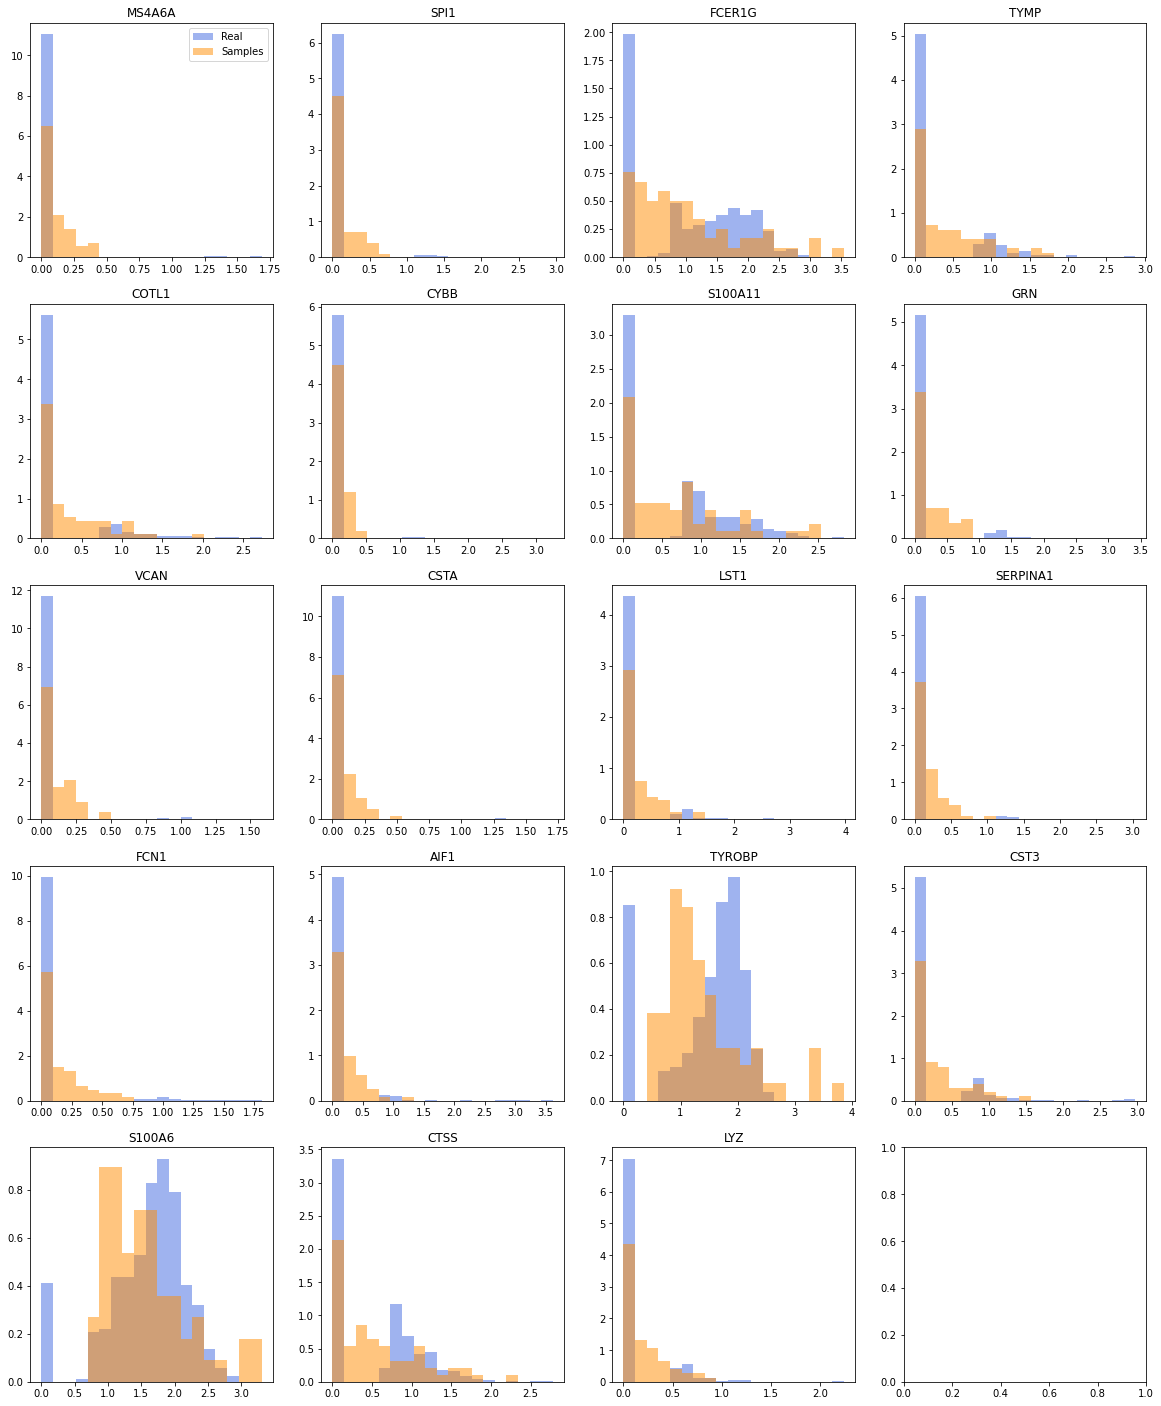

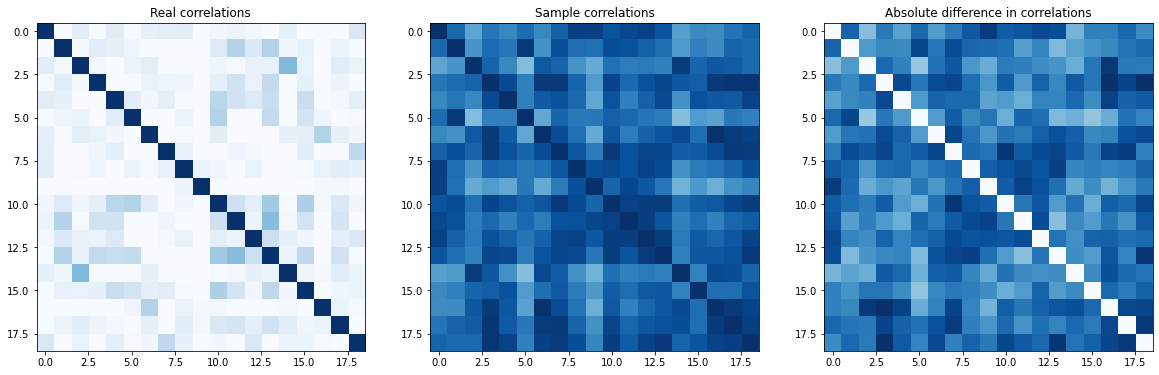

Class 2


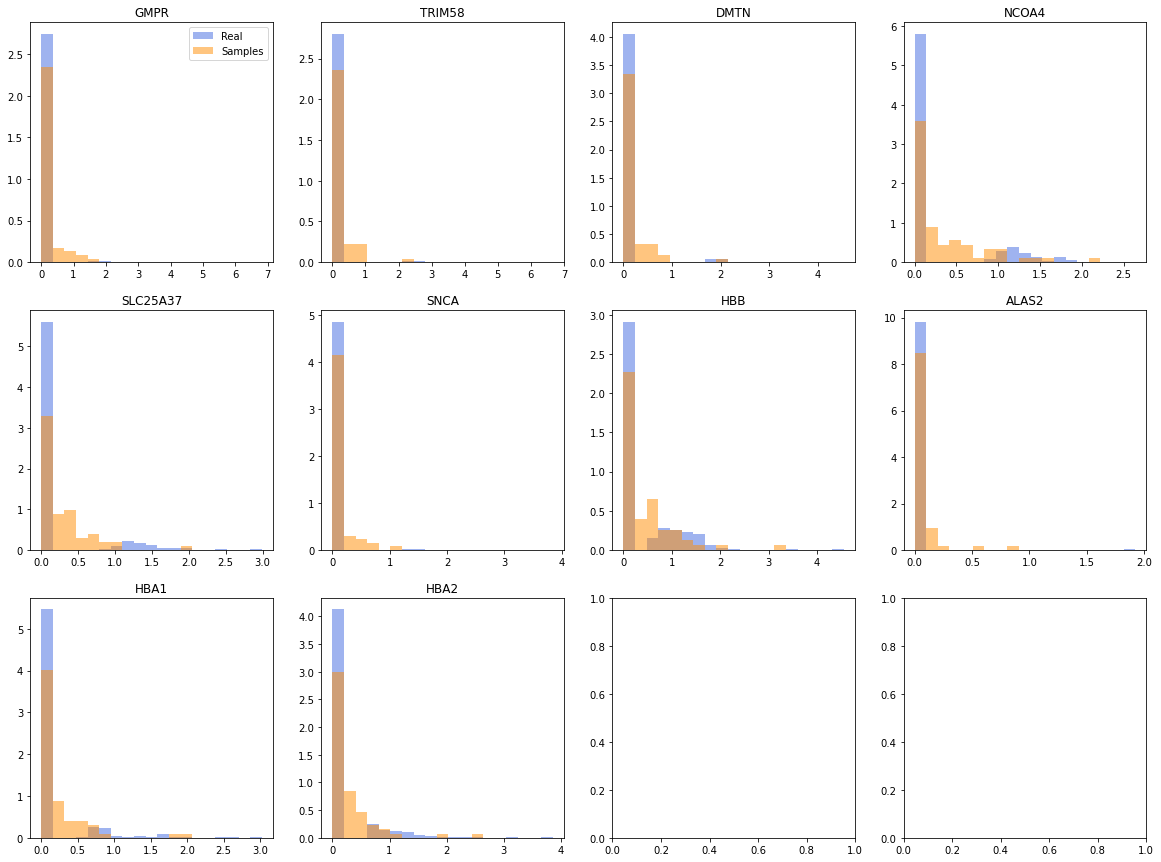

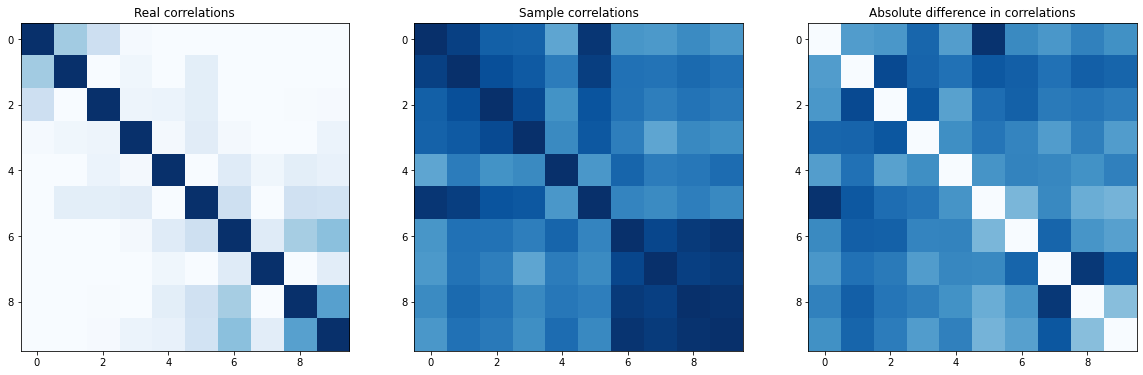

Class 3


/gstore/home/tsenga5/miniconda3/envs/scanpy/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/gstore/home/tsenga5/miniconda3/envs/scanpy/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


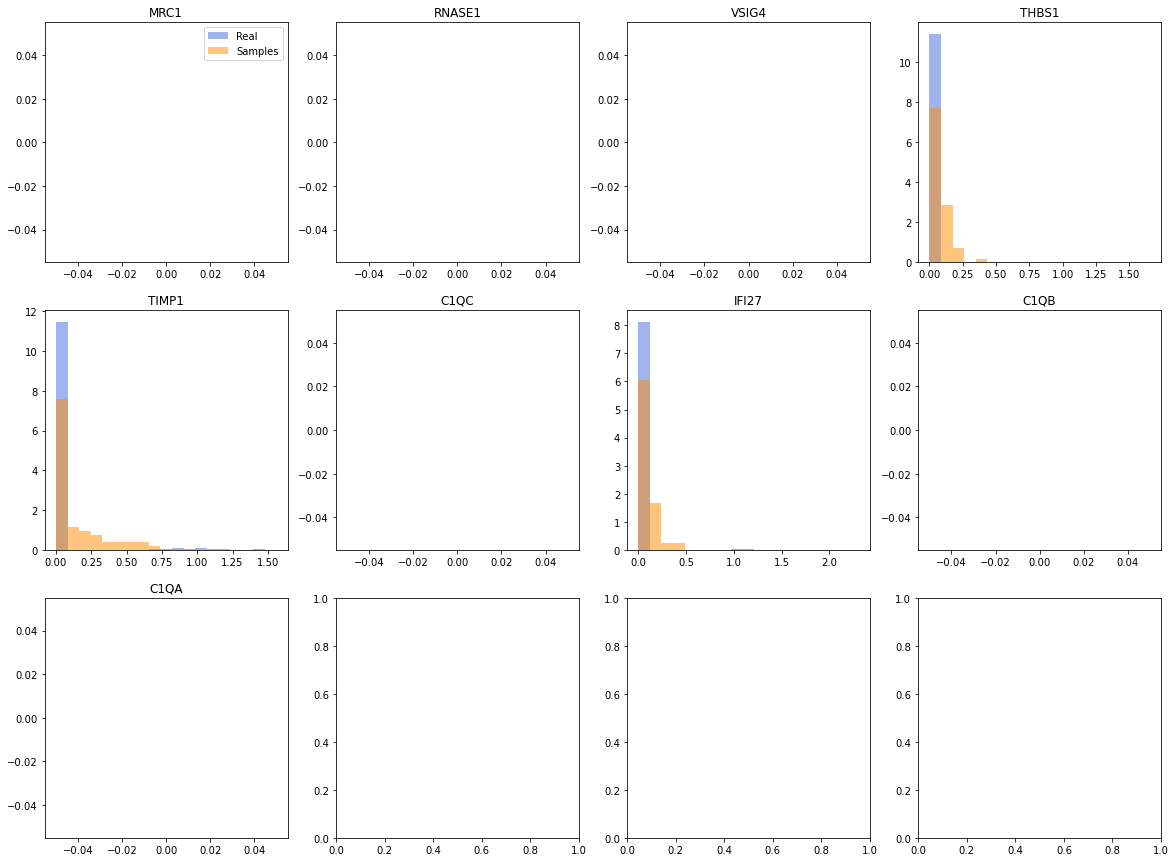

/gstore/home/tsenga5/miniconda3/envs/scanpy/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


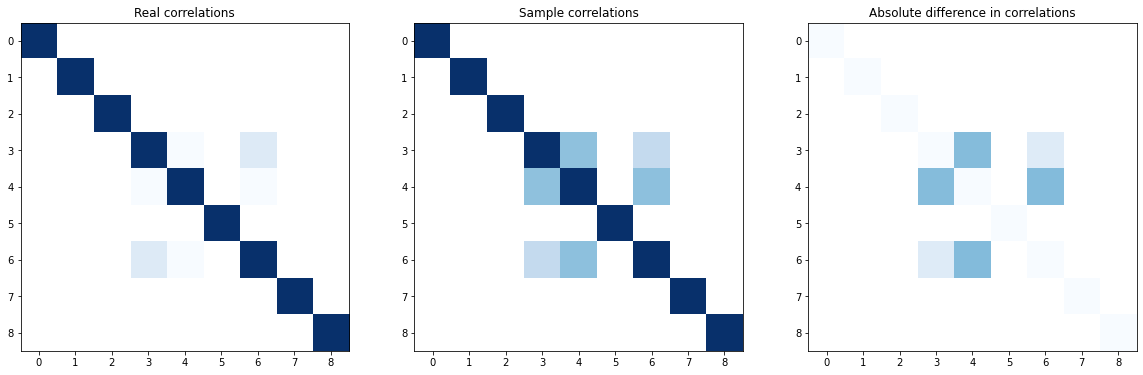

Class 4


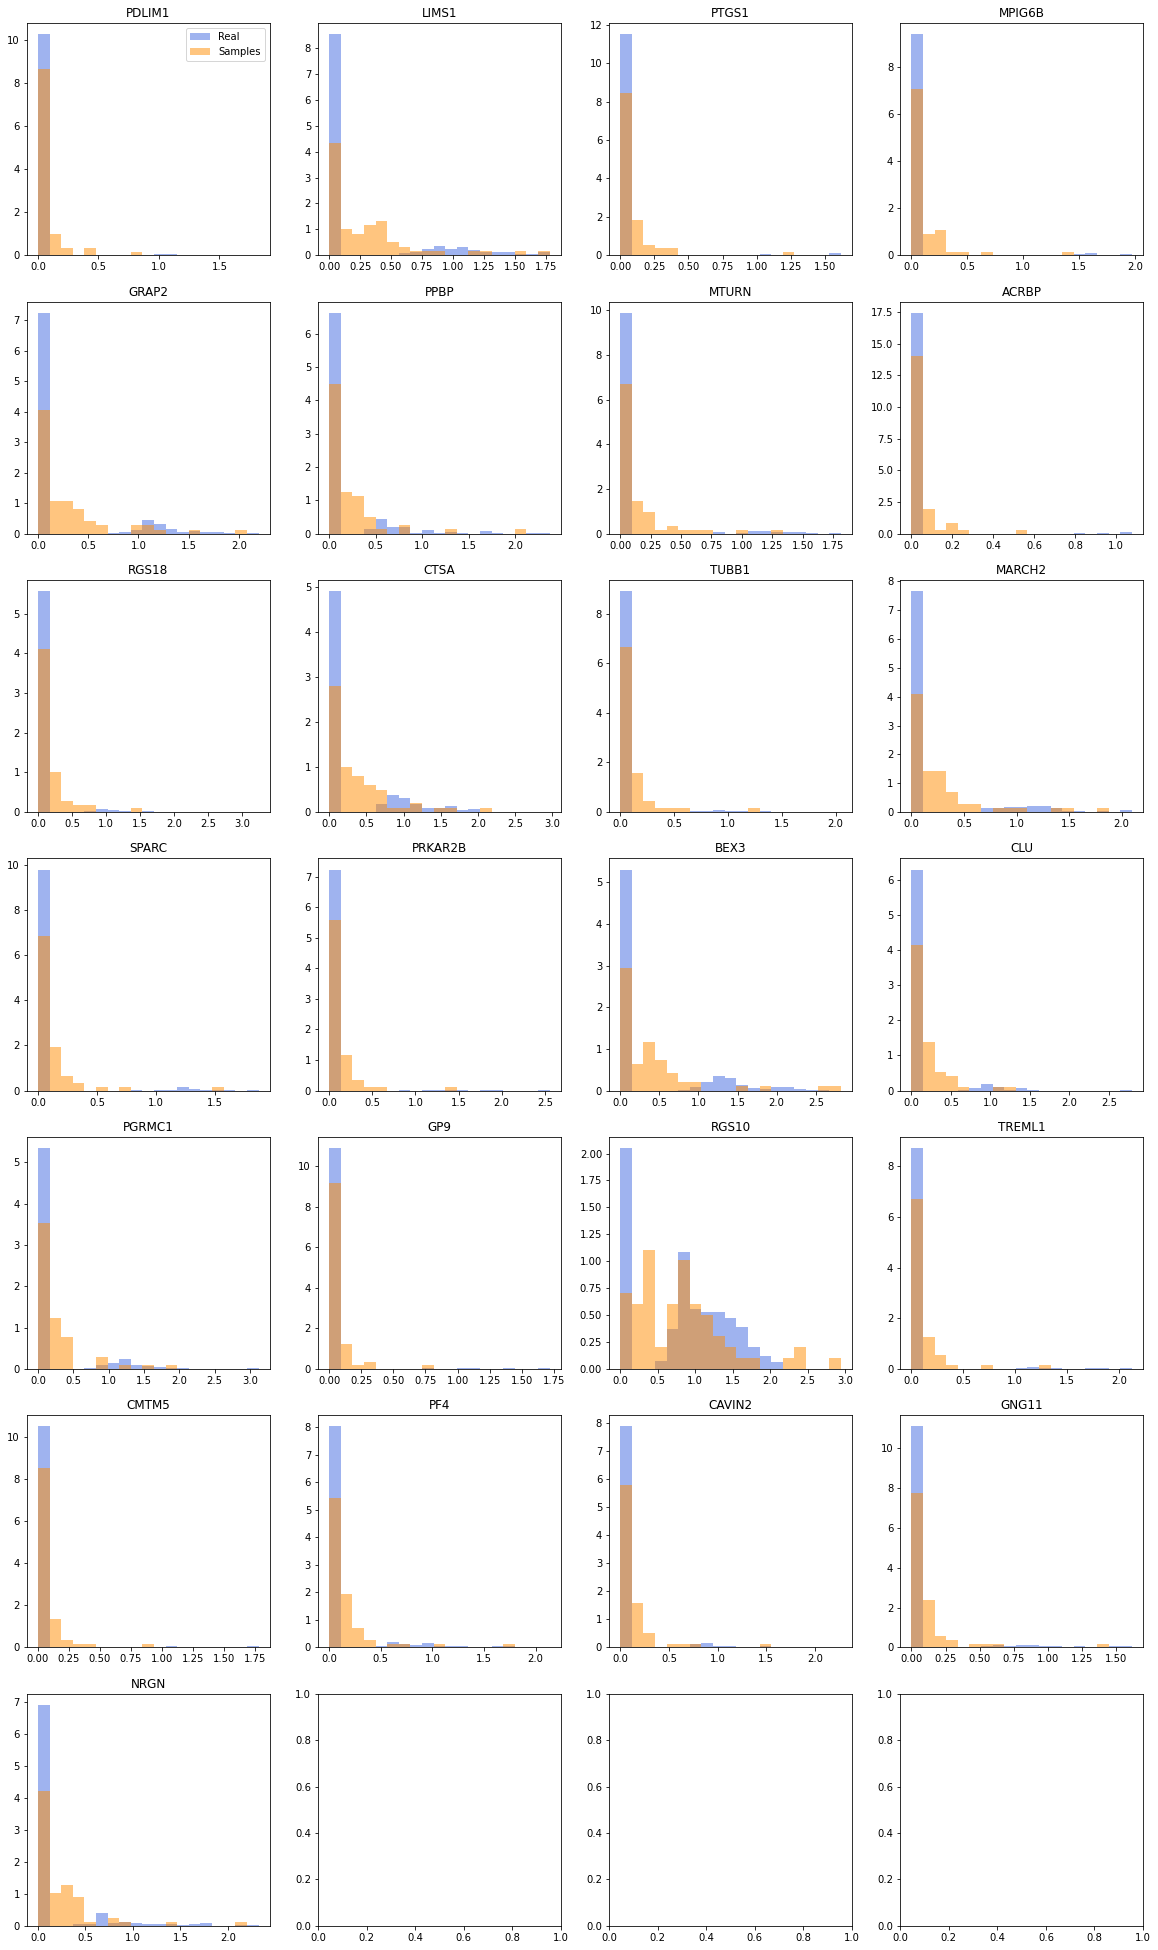

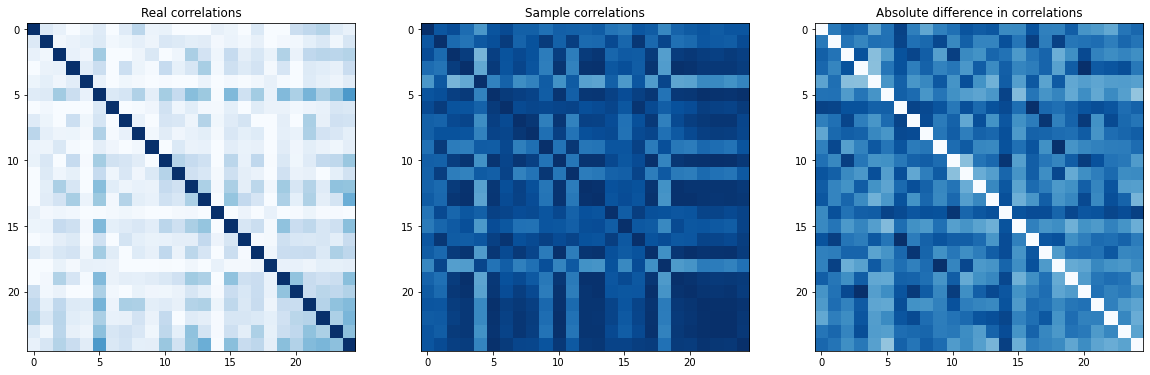

Class 5


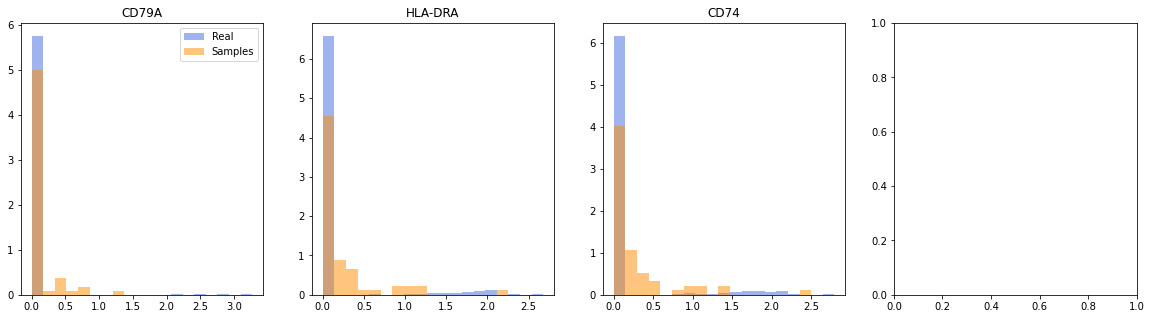

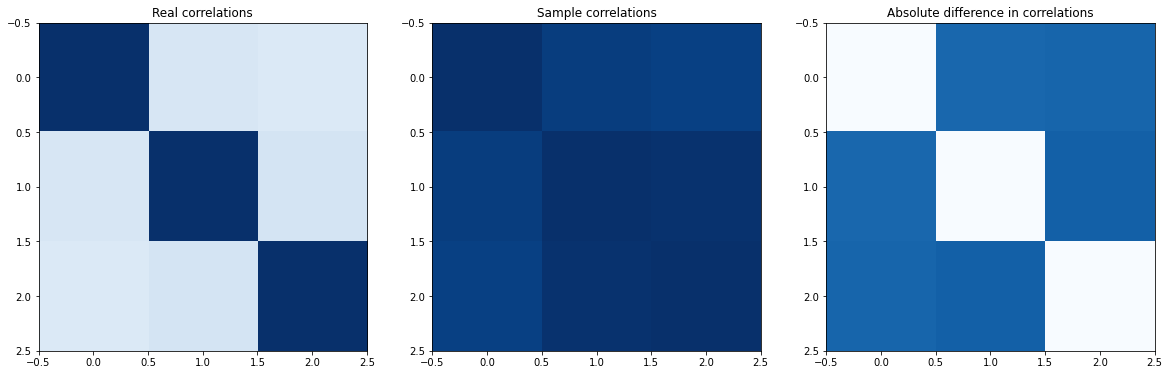

Class 7


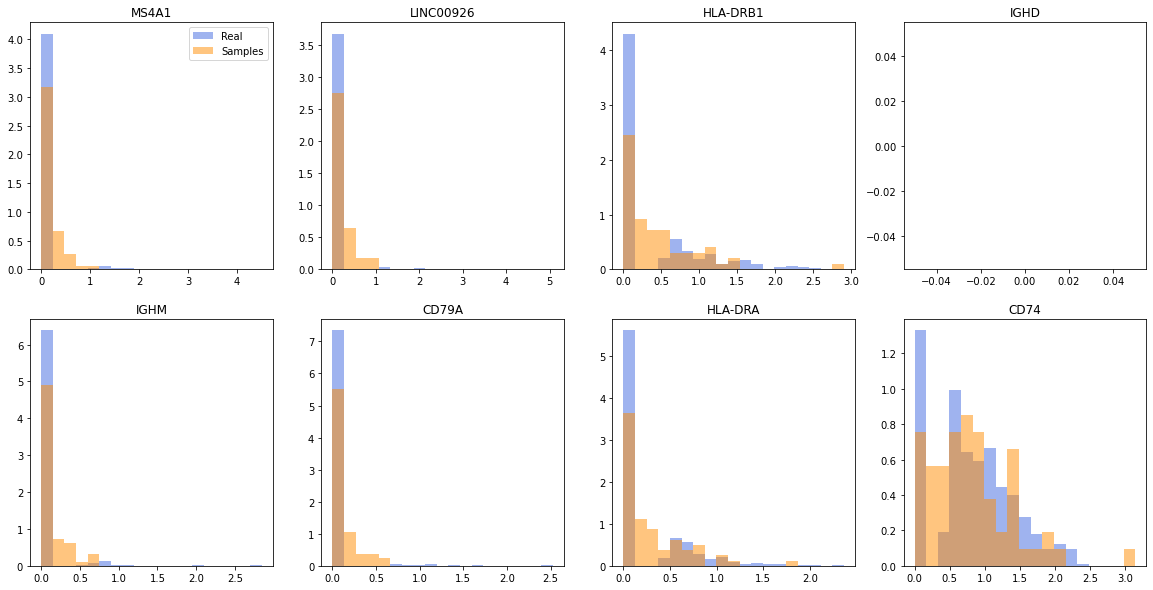

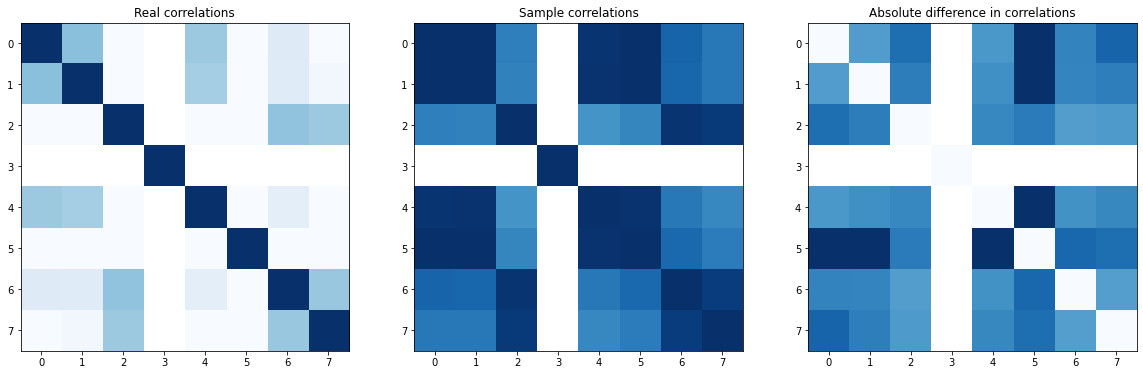

Class 10
Class 12


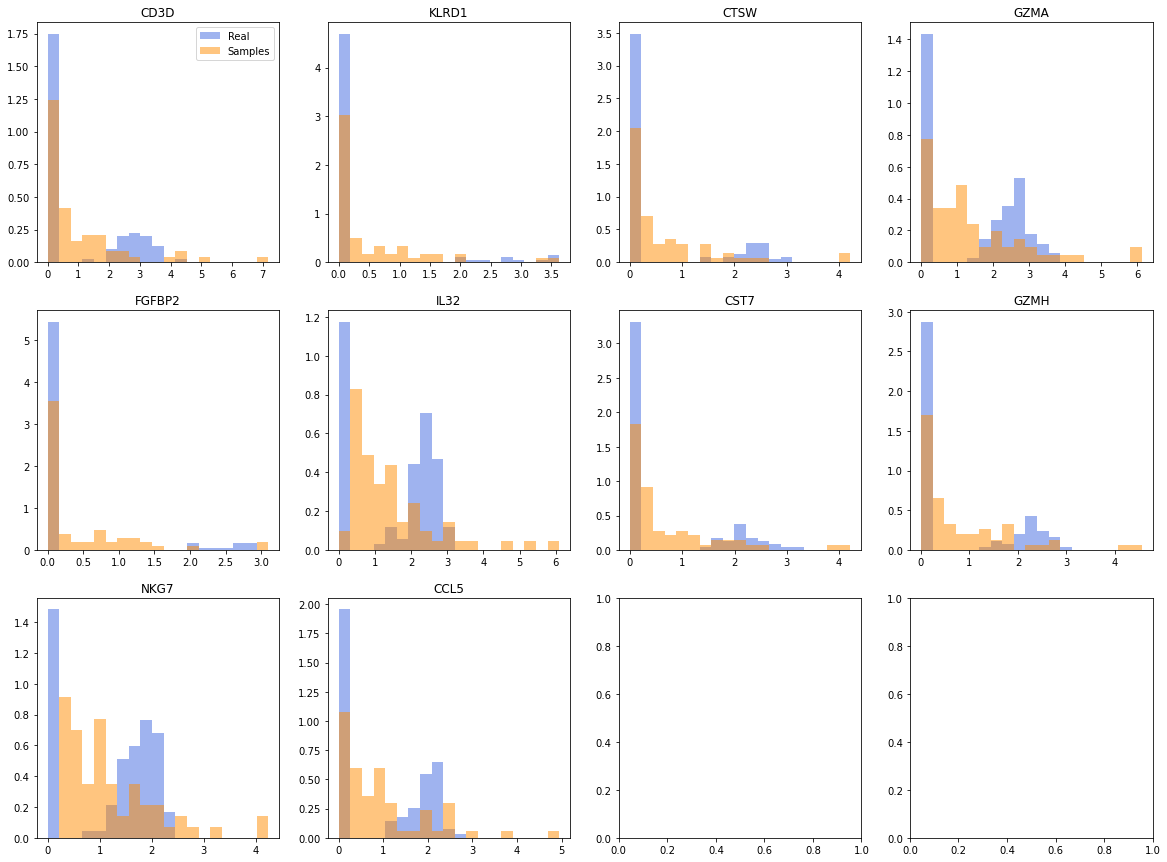

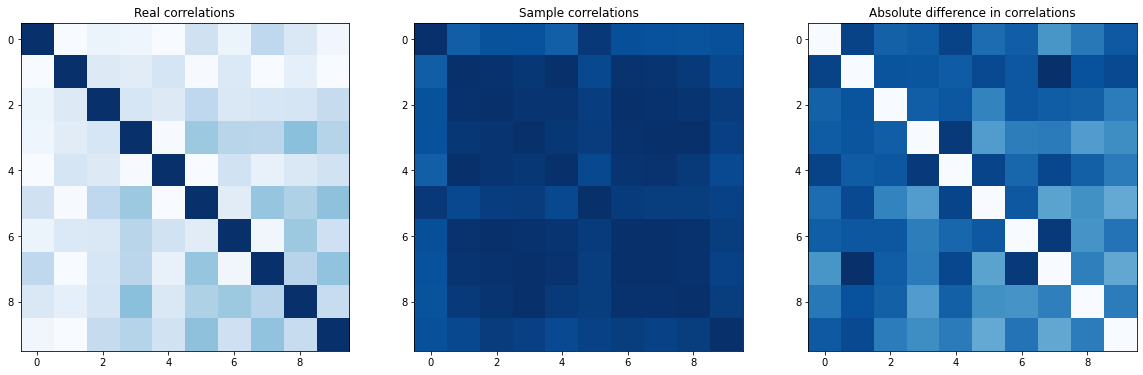

In [16]:
for class_to_sample in classes:
    print("Class %s" % class_to_sample)
    real = true_samples[class_to_sample]
    sample = gen_samples_scaled[class_to_sample]
    
    # Decide which features to plot
    feature_inds = []
    for gene in marker_genes[class_to_sample]:
        if gene in gene_names:
            feature_inds.append(np.where(gene_names == gene)[0][0])
    num_features = len(feature_inds)
    
    if not num_features:
        continue
    
    num_cols = 4
    num_rows = int(np.ceil(num_features / num_cols))
    num_bins = 20

    # Plot feature values
    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    if num_rows == 1:
        ax = [ax]
    for i, f_i in enumerate(feature_inds):
        r, c = i // num_cols, i % num_cols
        real_vals = real[:, f_i]
        sample_vals = sample[:, f_i]
        sample_vals[sample_vals < 0] = 0  # Threshold to 0
        all_vals = np.concatenate([real_vals, sample_vals])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax[r][c].hist(real_vals, bins=bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].hist(sample_vals, bins=bins, color="darkorange", label="Samples", density=True, alpha=0.5)
        ax[r][c].set_title(gene_names[f_i])
    ax[0][0].legend()
    plt.show()

    # Compute and plot correlations
    real_corrs = np.empty((num_features, num_features))
    sample_corrs = np.empty_like(real_corrs)
    for i, f_i in enumerate(feature_inds):
        real_corrs[i, i] = 1
        sample_corrs[i, i] = 1
        for j in range(i):
            f_j = feature_inds[j]
            real_corrs[i, j] = scipy.stats.pearsonr(real[:, f_i], real[:, f_j])[0]
            real_corrs[j, i] = real_corrs[i, j]
            sample_corrs[i, j] = scipy.stats.pearsonr(sample[:, f_i], sample[:, f_j])[0]
            sample_corrs[j, i] = sample_corrs[i, j]

    fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
    ax[0].imshow(real_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[0].set_title("Real correlations")
    ax[1].imshow(sample_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[1].set_title("Sample correlations")
    ax[2].imshow(np.abs(real_corrs - sample_corrs), cmap="Blues", vmin=0, vmax=1)
    ax[2].set_title("Absolute difference in correlations")
    plt.show()

### FID

In [17]:
for class_to_sample in classes:
    print("Class %s" % class_to_sample)
    real = true_samples[class_to_sample]
    sample = gen_samples[class_to_sample]
    fid_score = fid.compute_fid(real, sample)
    print(fid_score)

Class 0
376.3007087568904
Class 1
166.41475412063272
Class 2
153.1347445950001
Class 3
156.44289195498246
Class 4
65.50678765474073
Class 5
1610.1714775530236
Class 7
85.51768429435725
Class 10
317.5843459639036
Class 12
175.69228478369914
